# Check data flow


원본 데이터(이미지, txt) --> resize(ratio=0.1) --> resize(416x416) 


In [60]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=10, 10

In [61]:
# image data
train_path = './data/train/'
img_lst = os.listdir(train_path)
img_lst.sort()
print(len(img_lst))

1625


In [62]:
# txt data
train_txt_path = './data/train_annotation.txt'

df = pd.read_csv(train_txt_path, header=None)

df['title'] = df[0].str.split(' ').str[0]

df[0] = df[0].str.split(' ').str[1]

print('shape:', df.shape)
df.head()

shape: (1625, 31)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,title
0,8,143,98,233,1,198,141,288,231,2,...,700,148,754,5,155,699,211,755,6,./data/train/5820554de4b0ced31a7fd174.jpg
1,34,189,116,271,1,183,183,265,265,2,...,705,151,755,5,154,707,204,757,6,./data/train/58205570e4b0bb347e7dec70.jpg
2,0,129,96,227,1,182,131,272,221,2,...,740,136,798,5,142,741,196,795,6,./data/train/582055c0e4b0ced31a7fd17e.jpg
3,41,130,117,206,1,206,124,288,206,2,...,675,154,723,5,166,672,214,720,6,./data/train/582055fbe4b0ced31a7fd180.jpg
4,31,118,119,206,1,193,117,277,201,2,...,678,158,726,5,163,680,211,728,6,./data/train/58205636e4b0ced31a7fd182.jpg


shape: (758, 302, 3)


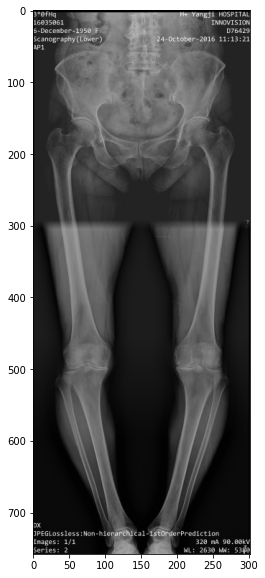

In [63]:
idx = 0

# show image with bbox and labels
img = cv2.imread(train_path + img_lst[idx])
sr = df.iloc[idx]

# ratio = 0.1
# resized_img = cv2.resize(img, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_AREA)

# bounding box
for i in range(0, 30, 5):
    start_x, start_y, end_x, end_y, label = int(sr[i]), int(sr[i+1]), int(sr[i+2]), int(sr[i+3]), int(sr[i+4]) 
    
#     img = cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (0, 0, 255), 1)
#     cv2.putText(img, str(label), (start_x, start_y), cv2.FONT_ITALIC, 1, (255, 0, 0), 1, cv2.LINE_AA)
    
print("shape:", img.shape)
    
plt.imshow(img)
plt.show()

In [27]:
# dataset
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision
import cv2

import random
import pandas as pd
import numpy as np

import utils.datasets as data
from utils import cosine_lr_scheduler
import utils.data_augment as dataAug
import utils.tools as tools
import config.yolov4_config as cfg

class BuildDataset(Dataset):
    def __init__(self, path, img_size=416):
        self.img_size = img_size
        self.classes = [1, 2, 3, 4, 5, 6]
        self.num_classes = len(self.classes)
        self.class_to_id = dict(zip(self.classes, range(self.num_classes)))
        anno_path = path
        with open(anno_path, "r") as f:
            annotations = list(filter(lambda x: len(x) > 0, f.readlines()))
        
        self.__annotations = annotations
        
    def __len__(self):
        return len(self.__annotations)
    
    def __getitem__(self, item):
        img_org, bboxes_org = self.__parse_annotation(self.__annotations[item])
        img_org = img_org.transpose(2, 0, 1)  # HWC->CHW
        
        item_mix = random.randint(0, len(self.__annotations) - 1)
        img_mix, bboxes_mix = self.__parse_annotation(
            self.__annotations[item_mix]
        )
        img_mix = img_mix.transpose(2, 0, 1)

        img, bboxes = dataAug.Mixup()(img_org, bboxes_org, img_mix, bboxes_mix)
        del img_org, bboxes_org, img_mix, bboxes_mix

        (
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        ) = self.__creat_label(bboxes)

        img = torch.from_numpy(img).float()
        label_sbbox = torch.from_numpy(label_sbbox).float()
        label_mbbox = torch.from_numpy(label_mbbox).float()
        label_lbbox = torch.from_numpy(label_lbbox).float()
        sbboxes = torch.from_numpy(sbboxes).float()
        mbboxes = torch.from_numpy(mbboxes).float()
        lbboxes = torch.from_numpy(lbboxes).float()

        return (
            img,
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        )
        
    
    def __parse_annotation(self, annotation):
        """
        Data augument.
        :param annotation: Image' path and bboxes' coordinates, categories.
        ex. [image_path xmin,ymin,xmax,ymax,class_ind xmin,ymin,xmax,ymax,class_ind ...]
        :return: Return the enhanced image and bboxes. bbox'shape is [xmin, ymin, xmax, ymax, class_ind]
        """
        anno = annotation.strip().split(" ")

        img_path = anno[0]
        img = cv2.imread(img_path)  # H*W*C and C=BGR
        assert img is not None, "File Not Found " + img_path
        bboxes = np.array(
            [list(map(float, box.split(","))) for box in anno[1:]]
        )

        img, bboxes = dataAug.RandomHorizontalFilp()(
            np.copy(img), np.copy(bboxes), img_path
        )
        img, bboxes = dataAug.RandomCrop()(np.copy(img), np.copy(bboxes))
        img, bboxes = dataAug.RandomAffine()(np.copy(img), np.copy(bboxes))
        img, bboxes = dataAug.Resize((self.img_size, self.img_size), True)(
            np.copy(img), np.copy(bboxes)
        )

        return img, bboxes
    
    def __creat_label(self, bboxes):
        """
        Label assignment. For a single picture all GT box bboxes are assigned anchor.
        1、Select a bbox in order, convert its coordinates("xyxy") to "xywh"; and scale bbox'
           xywh by the strides.
        2、Calculate the iou between the each detection layer'anchors and the bbox in turn, and select the largest
            anchor to predict the bbox.If the ious of all detection layers are smaller than 0.3, select the largest
            of all detection layers' anchors to predict the bbox.

        Note :
        1、The same GT may be assigned to multiple anchors. And the anchors may be on the same or different layer.
        2、The total number of bboxes may be more than it is, because the same GT may be assigned to multiple layers
        of detection.

        """

        anchors = np.array(cfg.MODEL["ANCHORS"])
        strides = np.array(cfg.MODEL["STRIDES"])
        train_output_size = self.img_size / strides
        anchors_per_scale = cfg.MODEL["ANCHORS_PER_SCLAE"]

        label = [
            np.zeros(
                (
                    int(train_output_size[i]),
                    int(train_output_size[i]),
                    anchors_per_scale,
                    6 + self.num_classes,
                )
            )
            for i in range(3)
        ]
        for i in range(3):
            label[i][..., 5] = 1.0

        bboxes_xywh = [
            np.zeros((150, 4)) for _ in range(3)
        ]  # Darknet the max_num is 30
        bbox_count = np.zeros((3,))

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = int(bbox[4])
            bbox_mix = bbox[5]

            # onehot
            one_hot = np.zeros(self.num_classes, dtype=np.float32)
            one_hot[bbox_class_ind] = 1.0
            one_hot_smooth = dataAug.LabelSmooth()(one_hot, self.num_classes)

            # convert "xyxy" to "xywh"
            bbox_xywh = np.concatenate(
                [
                    (bbox_coor[2:] + bbox_coor[:2]) * 0.5,
                    bbox_coor[2:] - bbox_coor[:2],
                ],
                axis=-1,
            )
            # print("bbox_xywh: ", bbox_xywh)

            bbox_xywh_scaled = (
                1.0 * bbox_xywh[np.newaxis, :] / strides[:, np.newaxis]
            )

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((anchors_per_scale, 4))
                anchors_xywh[:, 0:2] = (
                    np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                )  # 0.5 for compensation
                anchors_xywh[:, 2:4] = anchors[i]

                iou_scale = tools.iou_xywh_numpy(
                    bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh
                )
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(
                        np.int32
                    )

                    # Bug : 当多个bbox对应同一个anchor时，默认将该anchor分配给最后一个bbox
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:6] = bbox_mix
                    label[i][yind, xind, iou_mask, 6:] = one_hot_smooth

                    bbox_ind = int(bbox_count[i] % 150)  # BUG : 150为一个先验值,内存消耗大
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / anchors_per_scale)
                best_anchor = int(best_anchor_ind % anchors_per_scale)

                xind, yind = np.floor(
                    bbox_xywh_scaled[best_detect, 0:2]
                ).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:6] = bbox_mix
                label[best_detect][yind, xind, best_anchor, 6:] = one_hot_smooth

                bbox_ind = int(bbox_count[best_detect] % 150)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1

        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh

        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

In [28]:
train_anno_path = './data/train_annotation.txt'

train_dataset = BuildDataset(train_anno_path)

In [29]:
train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=1,
            num_workers=0,
            shuffle=True,
            pin_memory=True,
        )

In [34]:
for i in train_dataloader:
    print(len(i))
    print(i[0].shape)
    image = i[0]
    
    break

7
torch.Size([1, 3, 416, 416])


In [57]:
img = image.squeeze().permute(1, 2, 0)

img.shape

torch.Size([416, 416, 3])

Shape: torch.Size([416, 416, 3])


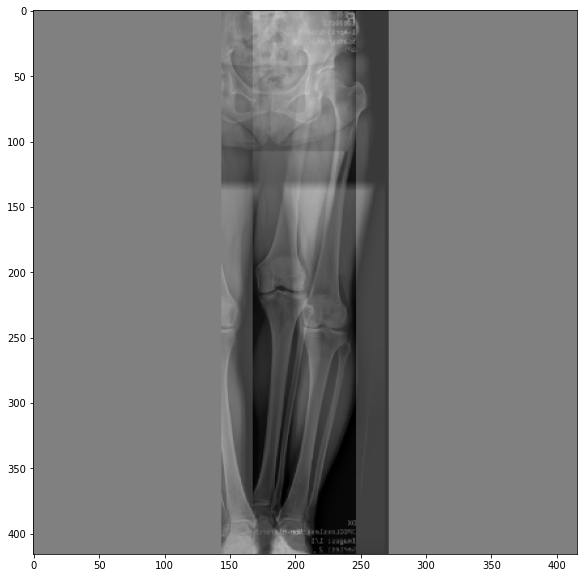

In [59]:
print("Shape:", img.shape)
plt.imshow(img)
plt.show()

# error 발견

이미지가 이상해진다.

내가 원하는건 이게 아니다.

수정하자 !

In [175]:
# dataset
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision
import cv2

import random
import pandas as pd
import numpy as np

import utils.datasets as data
from utils import cosine_lr_scheduler
import utils.data_augment as dataAug
import utils.tools as tools
import config.yolov4_config as cfg

class BuildDataset(Dataset):
    def __init__(self, path, img_size=416):
        self.img_size = img_size
        self.classes = ['1', '2', '3', '4', '5', '6']
        self.num_classes = len(self.classes)
        self.class_to_id = dict(zip(self.classes, range(self.num_classes)))
        anno_path = path
        with open(anno_path, "r") as f:
            annotations = list(filter(lambda x: len(x) > 0, f.readlines()))
        
        self.__annotations = annotations
        
    def __len__(self):
        return len(self.__annotations)
    
    def __getitem__(self, item):
        img_org, bboxes_org = self.__parse_annotation(self.__annotations[item])
        img_org = img_org.transpose(2, 0, 1)  # HWC->CHW
        
        # blur 같은 효과 부분
#         item_mix = random.randint(0, len(self.__annotations) - 1)
#         img_mix, bboxes_mix = self.__parse_annotation(
#             self.__annotations[item_mix]
#         )
#         img_mix = img_mix.transpose(2, 0, 1)

#         img, bboxes = dataAug.Mixup()(img_org, bboxes_org, img_mix, bboxes_mix)
#         del img_org, bboxes_org, img_mix, bboxes_mix

        img = img_org
        bboxes = bboxes_org
        
        (
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        ) = self.__creat_label(bboxes)

        img = torch.from_numpy(img).float()
        label_sbbox = torch.from_numpy(label_sbbox).float()
        label_mbbox = torch.from_numpy(label_mbbox).float()
        label_lbbox = torch.from_numpy(label_lbbox).float()
        sbboxes = torch.from_numpy(sbboxes).float()
        mbboxes = torch.from_numpy(mbboxes).float()
        lbboxes = torch.from_numpy(lbboxes).float()

        return (
            img,
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        )
        
    
    def __parse_annotation(self, annotation):
        """
        Data augument.
        :param annotation: Image' path and bboxes' coordinates, categories.
        ex. [image_path xmin,ymin,xmax,ymax,class_ind xmin,ymin,xmax,ymax,class_ind ...]
        :return: Return the enhanced image and bboxes. bbox'shape is [xmin, ymin, xmax, ymax, class_ind]
        """
        anno = annotation.strip().split(" ")
        print("------------------------------------------------------")
        print(anno)

        img_path = anno[0]
        img = cv2.imread(img_path)  # H*W*C and C=BGR
        assert img is not None, "File Not Found " + img_path
        bboxes = np.array(
            [list(map(float, box.split(","))) for box in anno[1:]]
        )
        print(bboxes)

#         img, bboxes = dataAug.RandomHorizontalFilp()(
#             np.copy(img), np.copy(bboxes), img_path
#         )
#         img, bboxes = dataAug.RandomCrop()(np.copy(img), np.copy(bboxes))
#         img, bboxes = dataAug.RandomAffine()(np.copy(img), np.copy(bboxes))
        img, bboxes = dataAug.Resize((self.img_size, self.img_size), True)(
            np.copy(img), np.copy(bboxes)
        )

        return img, bboxes
    
    def __creat_label(self, bboxes):
        """
        Label assignment. For a single picture all GT box bboxes are assigned anchor.
        1、Select a bbox in order, convert its coordinates("xyxy") to "xywh"; and scale bbox'
           xywh by the strides.
        2、Calculate the iou between the each detection layer'anchors and the bbox in turn, and select the largest
            anchor to predict the bbox.If the ious of all detection layers are smaller than 0.3, select the largest
            of all detection layers' anchors to predict the bbox.

        Note :
        1、The same GT may be assigned to multiple anchors. And the anchors may be on the same or different layer.
        2、The total number of bboxes may be more than it is, because the same GT may be assigned to multiple layers
        of detection.

        """

        anchors = np.array(cfg.MODEL["ANCHORS"])
        strides = np.array(cfg.MODEL["STRIDES"])
        train_output_size = self.img_size / strides
        anchors_per_scale = cfg.MODEL["ANCHORS_PER_SCLAE"]
        
        print("train_output_size: ", train_output_size)
        print("anchors_per_scale: ", anchors_per_scale)

        label = [
            np.zeros(
                (
                    int(train_output_size[i]),
                    int(train_output_size[i]),
                    anchors_per_scale,
                    6 + self.num_classes,
                )
            )
            for i in range(3)
        ]
        print("len label: ", len(label))
        print(label[0].shape)
        
        for i in range(3):
            label[i][..., 5] = 1.0

        bboxes_xywh = [
            np.zeros((150, 4)) for _ in range(3)
        ]  # Darknet the max_num is 30
        bbox_count = np.zeros((3,))
        
        print("bboxes")
        print(bboxes)

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = int(bbox[4])
            bbox_mix = bbox[5]
            print(bbox_mix)

            # onehot
            one_hot = np.zeros(self.num_classes, dtype=np.float32)
            one_hot[bbox_class_ind] = 1.0
            print("one hot: ", one_hot)
            one_hot_smooth = dataAug.LabelSmooth()(one_hot, self.num_classes)
            print(one_hot_smooth)

            # convert "xyxy" to "xywh"
            bbox_xywh = np.concatenate(
                [
                    (bbox_coor[2:] + bbox_coor[:2]) * 0.5,
                    bbox_coor[2:] - bbox_coor[:2],
                ],
                axis=-1,
            )
            # print("bbox_xywh: ", bbox_xywh)

            bbox_xywh_scaled = (
                1.0 * bbox_xywh[np.newaxis, :] / strides[:, np.newaxis]
            )

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((anchors_per_scale, 4))
                anchors_xywh[:, 0:2] = (
                    np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                )  # 0.5 for compensation
                anchors_xywh[:, 2:4] = anchors[i]

                iou_scale = tools.iou_xywh_numpy(
                    bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh
                )
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3
                print(iou_mask)

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(
                        np.int32
                    )

                    # Bug : 当多个bbox对应同一个anchor时，默认将该anchor分配给最后一个bbox
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:6] = bbox_mix
                    label[i][yind, xind, iou_mask, 6:] = one_hot_smooth

                    bbox_ind = int(bbox_count[i] % 150)  # BUG : 150为一个先验值,内存消耗大
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / anchors_per_scale)
                best_anchor = int(best_anchor_ind % anchors_per_scale)

                xind, yind = np.floor(
                    bbox_xywh_scaled[best_detect, 0:2]
                ).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:6] = bbox_mix
                label[best_detect][yind, xind, best_anchor, 6:] = one_hot_smooth

                bbox_ind = int(bbox_count[best_detect] % 150)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1
                
            print("len label", len(label))

        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh

        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

In [176]:
train_anno_path = './data/train_annotation.txt'

train_dataset = BuildDataset(train_anno_path)

train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=1,
            num_workers=0,
            shuffle=True,
            pin_memory=True,
        )

print(len(train_dataloader))

1625


In [193]:
for i, (img, label_sbbox,
        label_mbbox, label_lbbox,
        sbboxes, mbboxes, lbboxes,) in enumerate(train_dataloader):
    print("*************************")
    print(img.shape)
    
    
    if i == 2:
        break

------------------------------------------------------
['./data/train/5a823c7ee4b05b48a53d9d5e.jpg', '10,110,96,196,1,189,117,267,195,2,25,391,111,477,3,174,398,254,478,4,86,641,136,691,5,154,643,204,691,6']
[[ 10. 110.  96. 196.   1. 189. 117. 267. 195.   2.  25. 391. 111. 477.
    3. 174. 398. 254. 478.   4.  86. 641. 136. 691.   5. 154. 643. 204.
  691.   6.]]
train_output_size:  [52. 26. 13.]
anchors_per_scale:  3
len label:  3
(52, 52, 3, 12)
bboxes
[[123.01156069  66.12716763 174.71098266 117.8265896    1.
  189.         117.         267.         195.           2.
   25.         391.         111.         477.           3.
  174.         398.         254.         478.           4.
   86.         641.         136.         691.           5.
  154.         643.         204.         691.           6.        ]]
189.0
one hot:  [0. 1. 0. 0. 0. 0.]
[0.00166667 0.9916667  0.00166667 0.00166667 0.00166667 0.00166667]
[False False False]
[ True  True  True]
[False False False]
len label 3
*

Shape: torch.Size([416, 416, 3])


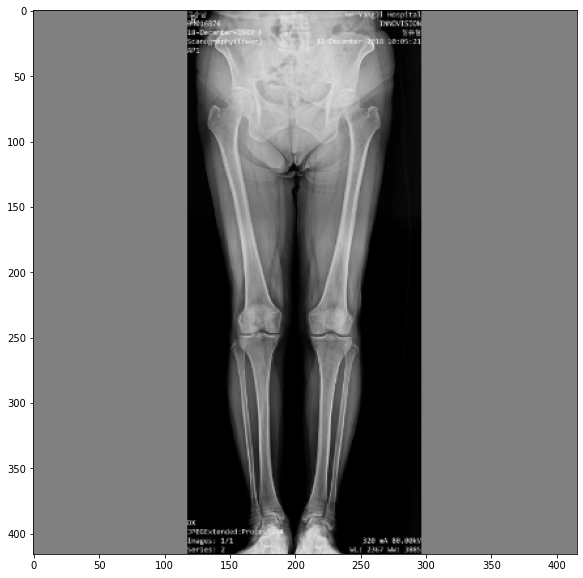

In [194]:
img = image.squeeze().permute(1, 2, 0)

print("Shape:", img.shape)
plt.imshow(img)
plt.show()

In [179]:
i[3].shape

torch.Size([1, 13, 13, 3, 12])

In [181]:
i[3].squeeze().shape

torch.Size([13, 13, 3, 12])

In [187]:
i[3].squeeze()[1][0]

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [190]:
i[3].squeeze()[0][0]

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])